In [1]:
import numpy as np
import pandas as pd
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from xgboost import plot_importance

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


<h1>Tabular Playground Series - May 2022 - Modelling</h1>


In [2]:
def evaluate_model(model, x, y):
    y_pred_prob = model.predict_proba(x)[:, 1]
    auc_roc = roc_auc_score(y, y_pred_prob)
    return {'auc_roc_curve' : auc_roc}

In [3]:
def encode_sequence_of_chars(df, feature):
    return df[feature].map(lambda string: np.std(list(map(ord, string))))

In [4]:
def get_xgb_baseline(params={}):
    return XGBClassifier(**params,
                         objective='binary:logistic',
                         tree_method='gpu_hist',
                         predictor='gpu_predictor',
                         random_state=seed,
                         verbosity=0)

In [5]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv')

In [6]:
train_df.drop('id', axis=1, inplace=True)
target = train_df.pop('target')

In [7]:
seed = 47

<h2>1. Feature engineering<h2>

<h3>1.1 Encoding the feature f_27</h3>

In [8]:
train_df['f_27'] = encode_sequence_of_chars(train_df, 'f_27')

<h3>1.2 Adding Synthetic features</h3>

In [9]:
geomean = lambda x, axis : np.exp(np.mean(np.log(x), axis=axis))
harmonic_mean = lambda x, axis : len(x) / np.sum(1.0/x, axis=axis) 

funcs = {'mean' : np.mean, 
         'std' : np.std, 
         'var' : np.var, 
         'geo_mean' : geomean, 
         'harmonic_mean' : harmonic_mean, 
         'median' : np.median,
         'none': None}

results, names = list(), list()

for key in funcs.keys():
    x_train = train_df.copy()
    y_train = target
    if funcs[key] is not None:
        x_train[key] = funcs[key](x_train, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seed, shuffle=False)       
    model = get_xgb_baseline()

    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    names.append(key)
    results.append(result['auc_roc_curve'])
    
for name, score in zip(names, results):
    print('>%s: %f' % (name, score))

index_best = np.argmax(results)
print('Best result is of:', names[index_best], 'with score:', results[index_best])


>mean: 0.929183
>std: 0.927214
>var: 0.927214
>geo_mean: 0.927748
>harmonic_mean: 0.925360
>median: 0.927056
>none: 0.925360
Best result is of: mean with score: 0.9291829586834612


<h2>2. Spliting the dataset into train/test with sizes 80%-20%</h2> 

In [10]:
x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=seed, shuffle=False)

<h2>3. Tabular Playground Series - Apr 2022 - XGBoost</h2>

<h3>3.1 Baseline - XGBoost</h3>

In [11]:
model = XGBClassifier(objective='binary:logistic',
                      tree_method='gpu_hist',
                      predictor='gpu_predictor',
                      random_state=seed,
                      verbosity=0)

model.fit(x_train, y_train)
score = evaluate_model(model, x_test, y_test)
print(score)

{'auc_roc_curve': 0.9253595761220319}


<h3>3.1 Manual Grid Search - XGBoost</h3>

In [12]:
train_df['mean'] = np.mean(train_df, axis=1)
x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=seed, shuffle=False)
params = {}

<h4>3.1.1 - Testing different number of estimators<h4>

In [13]:
results_trees = {}
trees = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 950, 975, 1000, 1025, 1050, 1100, 1150, 1290, 1295, 1300, 1305, 1310, 1315, 1325, 2000, 3000, 4000, 5000, 10000]

for n in trees:
    params['n_estimators'] = n
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_trees[n] = result['auc_roc_curve']
    print('n_estimators:', n, 'auc_roc_score:', results_trees[n])

best_nestimator = max(results_trees, key=results_trees.get)
print('\nBest n_estimators:', best_nestimator, 'AUC ROC score:', results_trees[best_nestimator])

n_estimators: 50 auc_roc_score: 0.9074345059564253
n_estimators: 100 auc_roc_score: 0.9291829586834612
n_estimators: 150 auc_roc_score: 0.9363120909051308
n_estimators: 200 auc_roc_score: 0.9404824282225706
n_estimators: 250 auc_roc_score: 0.9424582600999044
n_estimators: 300 auc_roc_score: 0.9442717273305439
n_estimators: 350 auc_roc_score: 0.9449702793942683
n_estimators: 400 auc_roc_score: 0.945790389439213
n_estimators: 450 auc_roc_score: 0.9459248351469284
n_estimators: 500 auc_roc_score: 0.9461271892311258
n_estimators: 600 auc_roc_score: 0.9461881148149763
n_estimators: 700 auc_roc_score: 0.9465468520103958
n_estimators: 800 auc_roc_score: 0.946659165721808
n_estimators: 900 auc_roc_score: 0.9466418624067631
n_estimators: 950 auc_roc_score: 0.9466201100826277
n_estimators: 975 auc_roc_score: 0.9466308565470519
n_estimators: 1000 auc_roc_score: 0.9466144317412654
n_estimators: 1025 auc_roc_score: 0.9465187895051757
n_estimators: 1050 auc_roc_score: 0.9465583649851129
n_estimators

<h4>3.1.2 - Testing different max_depth</h4>

In [14]:
results_max_depths = {}
params['n_estimators'] = best_nestimator
max_depths = [i for i in range(1,25)]

for max_depth in max_depths:
    params['max_depth'] = max_depth
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_max_depths[max_depth] = result['auc_roc_curve']
    print('max_depth:', max_depth, 'auc_roc_score:', results_max_depths[max_depth])

best_max_depth = max(results_max_depths, key=results_max_depths.get)
print('\nBest max_depth:', best_max_depth, 'AUC ROC score:', results_max_depths[best_max_depth])

max_depth: 1 auc_roc_score: 0.7304998032898482
max_depth: 2 auc_roc_score: 0.8938531004953711
max_depth: 3 auc_roc_score: 0.9255183928169485
max_depth: 4 auc_roc_score: 0.9390439265470756
max_depth: 5 auc_roc_score: 0.9446902210704209
max_depth: 6 auc_roc_score: 0.946659165721808
max_depth: 7 auc_roc_score: 0.9466265747642159
max_depth: 8 auc_roc_score: 0.9468954751988685
max_depth: 9 auc_roc_score: 0.9469030055076774
max_depth: 10 auc_roc_score: 0.9481949576181675
max_depth: 11 auc_roc_score: 0.9494554580964474
max_depth: 12 auc_roc_score: 0.9502220253464778
max_depth: 13 auc_roc_score: 0.9510910551556881
max_depth: 14 auc_roc_score: 0.9511263049921908
max_depth: 15 auc_roc_score: 0.9512584834158335
max_depth: 16 auc_roc_score: 0.9516496021499304
max_depth: 17 auc_roc_score: 0.9516047587032177
max_depth: 18 auc_roc_score: 0.9519025492493443
max_depth: 19 auc_roc_score: 0.9517230378884747
max_depth: 20 auc_roc_score: 0.952073007226673
max_depth: 21 auc_roc_score: 0.9519042407240649
max

<h4>3.1.3 - Testing different subsamples</h4>


In [15]:
results_subsamples = {}
params['max_depth'] = best_max_depth
subsamples = [i for i in np.arange(0.1, 1.1, 0.1)]

for subsample in subsamples:
    params['subsample'] = subsample
    model = model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_subsamples[subsample] = result['auc_roc_curve']
    print('subsample:', subsample, 'auc_roc_score:', results_subsamples[subsample])

best_subsample = max(results_subsamples, key=results_subsamples.get)
print('\nBest subsample:', best_subsample, 'AUC ROC score:', results_subsamples[best_subsample])

subsample: 0.1 auc_roc_score: 0.8398709764506855
subsample: 0.2 auc_roc_score: 0.9142584762097226
subsample: 0.30000000000000004 auc_roc_score: 0.9321976352644723
subsample: 0.4 auc_roc_score: 0.9400078811935979
subsample: 0.5 auc_roc_score: 0.9441637086836984
subsample: 0.6 auc_roc_score: 0.9471680383023859
subsample: 0.7000000000000001 auc_roc_score: 0.9487992211939134
subsample: 0.8 auc_roc_score: 0.9503299477471082
subsample: 0.9 auc_roc_score: 0.9511013656086964
subsample: 1.0 auc_roc_score: 0.952073007226673

Best subsample: 1.0 AUC ROC score: 0.952073007226673


<h4>3.1.4 - Testing different learning rates</h4>

In [16]:
results_etas = {}
params['subsample'] = best_subsample
etas = [0.0001, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.12, 0.13, 0.3, 0.5, 1.0]

for eta in etas:
    params['eta'] = eta
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_etas[eta] = result['auc_roc_curve']
    print('eta:', eta, 'auc_roc_score:', results_etas[eta])

best_eta = max(results_etas, key=results_etas.get)
print('\nBest eta:', best_eta, 'AUC ROC score:', results_etas[best_eta])

eta: 0.0001 auc_roc_score: 0.8778447544288479
eta: 0.001 auc_roc_score: 0.9158681005668301
eta: 0.003 auc_roc_score: 0.9338252345597635
eta: 0.005 auc_roc_score: 0.9406235818219824
eta: 0.01 auc_roc_score: 0.9469655628293485
eta: 0.03 auc_roc_score: 0.9518235002808051
eta: 0.05 auc_roc_score: 0.9528620738518521
eta: 0.1 auc_roc_score: 0.9538013473364328
eta: 0.12 auc_roc_score: 0.9534021904989906
eta: 0.13 auc_roc_score: 0.9534488802298047
eta: 0.3 auc_roc_score: 0.952073007226673
eta: 0.5 auc_roc_score: 0.9490402445733699
eta: 1.0 auc_roc_score: 0.9409330230403956

Best eta: 0.1 AUC ROC score: 0.9538013473364328


<h4>3.1.5 - Testing different number of features<h4>

In [17]:
results_colsample_bytrees = {}
params['eta'] = best_eta
colsample_bytrees = [i for i in np.arange(0.1, 1.1, 0.1)]

for colsample_bytree in colsample_bytrees:
    params['colsample_bytree'] = colsample_bytree
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_colsample_bytrees[colsample_bytree] = result['auc_roc_curve']
    print('colsample_bytree:', colsample_bytree, 'auc_roc_score:', results_colsample_bytrees[colsample_bytree])

best_colsample_bytree = max(results_colsample_bytrees, key=results_colsample_bytrees.get)
print('\nBest colsample_bytree:', best_colsample_bytree, 'AUC ROC score:', results_colsample_bytrees[best_colsample_bytree])

colsample_bytree: 0.1 auc_roc_score: 0.8174465844548754
colsample_bytree: 0.2 auc_roc_score: 0.8997249142943053
colsample_bytree: 0.30000000000000004 auc_roc_score: 0.9225048724260281
colsample_bytree: 0.4 auc_roc_score: 0.9355090606715044
colsample_bytree: 0.5 auc_roc_score: 0.9447673044046101
colsample_bytree: 0.6 auc_roc_score: 0.9485602208382377
colsample_bytree: 0.7000000000000001 auc_roc_score: 0.9507154853744657
colsample_bytree: 0.8 auc_roc_score: 0.9523796915284715
colsample_bytree: 0.9 auc_roc_score: 0.952968208284445
colsample_bytree: 1.0 auc_roc_score: 0.9538013473364328

Best colsample_bytree: 1.0 AUC ROC score: 0.9538013473364328


<h4>3.1.6 - Testing different values for min_child_weight<h4>

In [18]:
results_min_child_weight = {}
params['colsample_bytree'] = best_colsample_bytree
min_child_weights = [i for i in range(1,10)]

for min_child_weight in min_child_weights:
    params['min_child_weight'] = min_child_weight
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_min_child_weight[min_child_weight] = result['auc_roc_curve']
    print('min_child_weight:', min_child_weight, 'auc_roc_score:', results_min_child_weight[min_child_weight])

best_min_child_weight = max(results_min_child_weight, key=results_min_child_weight.get)
print('\nBest min_child_weight:', best_min_child_weight, 'AUC ROC score:', results_min_child_weight[best_min_child_weight])

min_child_weight: 1 auc_roc_score: 0.9538013473364328
min_child_weight: 2 auc_roc_score: 0.9536930287078027
min_child_weight: 3 auc_roc_score: 0.9535253732991767
min_child_weight: 4 auc_roc_score: 0.9534796718526687
min_child_weight: 5 auc_roc_score: 0.9537779170046339
min_child_weight: 6 auc_roc_score: 0.953692785930123
min_child_weight: 7 auc_roc_score: 0.9536683426655972
min_child_weight: 8 auc_roc_score: 0.9536633764720956
min_child_weight: 9 auc_roc_score: 0.9535496099246848

Best min_child_weight: 1 AUC ROC score: 0.9538013473364328


<h4>3.1.7 - Testing different values for gamma<h4>

In [19]:
results_gamma = {}
params['min_child_weight'] = best_min_child_weight
gammas = [0, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1, 1.1, 1.5, 2, 5, 7, 9, 10]

for gamma in gammas:
    params['gamma'] = gamma
    model = get_xgb_baseline(params)
    model.fit(x_train, y_train)
    result = evaluate_model(model, x_test, y_test)
    results_gamma[gamma] = result['auc_roc_curve']
    print('gamma:', gamma, 'auc_roc_score:', results_gamma[gamma])

best_gamma = max(results_gamma, key=results_gamma.get)
print('\nBest gamma:', best_gamma, 'AUC ROC:', results_gamma[best_gamma])

gamma: 0 auc_roc_score: 0.9538013473364328
gamma: 0.01 auc_roc_score: 0.9537791081596524
gamma: 0.02 auc_roc_score: 0.9534179432492099
gamma: 0.03 auc_roc_score: 0.9530209029018669
gamma: 0.1 auc_roc_score: 0.9520471958203467
gamma: 0.3 auc_roc_score: 0.9504015170627411
gamma: 0.5 auc_roc_score: 0.9497816666039697
gamma: 1 auc_roc_score: 0.9487053377678293
gamma: 1.1 auc_roc_score: 0.9486299777227387
gamma: 1.5 auc_roc_score: 0.9482292115719789
gamma: 2 auc_roc_score: 0.9474966371507592
gamma: 5 auc_roc_score: 0.948175808575001
gamma: 7 auc_roc_score: 0.9480254147829634
gamma: 9 auc_roc_score: 0.9474231755282841
gamma: 10 auc_roc_score: 0.9466236416021252

Best gamma: 0 AUC ROC: 0.9538013473364328


In [20]:
params['gamma'] = best_gamma
print('Best Hyperparameters:', params)

Best Hyperparameters: {'n_estimators': 800, 'max_depth': 20, 'subsample': 1.0, 'eta': 0.1, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'gamma': 0}


<h2>4. Submission</h2>

<h2>4.1 Train model with the best found params</h2>


In [21]:
model = get_xgb_baseline(params)
model.fit(x_train, y_train)
result = evaluate_model(model, x_test, y_test)
print(result)

{'auc_roc_curve': 0.9538013473364328}


<h3>Importance features plot</h3>


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

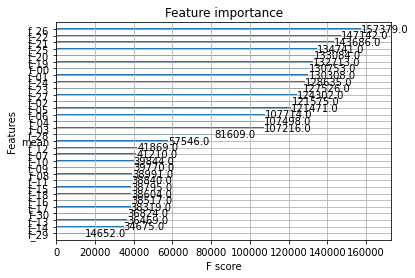

In [22]:
plot_importance(model)

In [23]:
del train_df, x_train, y_train, x_test, y_test
gc.collect()

51

In [24]:
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv')

In [25]:
ids = test_df.pop('id')
test_df['f_27'] = encode_sequence_of_chars(test_df, 'f_27')
test_df['mean'] = np.mean(test_df, axis=1)

In [26]:
target = model.predict_proba(test_df)[:,1]
submission = pd.DataFrame({'id' : ids, 'target' : target})

In [27]:
submission.head()

,id,target
0,900000,0.999908
1,900001,0.999838
2,900002,0.000022
3,900003,0.010992
4,900004,0.996695


In [28]:
submission.to_csv('submission.csv', index=False)